# **Step 1: Setup & Import with Error Handling**


In [ ]:
!pip install wordcloud

# =============================
# PHASE 1: SETUP & DATA LOADING
# =============================


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Optimized display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')  # Using default style for better compatibility
sns.set_palette("husl")

# ================================
# UPLOAD YOUR FILE TO GOOGLE COLAB
# ================================

In [3]:
from google.colab import files
import io

print("📤 STEP 1: Please upload your 'netflix1.csv' file...")
uploaded = files.upload()

# Get the uploaded filename
file_name = list(uploaded.keys())[0]
print(f"📁 Uploaded file: {file_name}")

# Load the data with optimized settings
def load_netflix_data(uploaded_files, file_name):
    """Load Netflix data with memory optimization"""
    try:
        # Define optimized data types to save memory
        dtypes = {
            'show_id': 'category',
            'type': 'category',
            'rating': 'category',
            'country': 'category'
        }

        # Read the uploaded file
        data = pd.read_csv(io.BytesIO(uploaded_files[file_name]), dtype=dtypes)

        print("✅ Data loaded successfully!")
        print(f"📊 Dataset shape: {data.shape}")
        return data

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

📤 STEP 1: Please upload your 'netflix1.csv' file...


Saving netflix1.csv to netflix1.csv
📁 Uploaded file: netflix1.csv


In [4]:
# Load the data
df = load_netflix_data(uploaded, file_name)

if df is not None:
    # Quick overview
    print("\n" + "="*50)
    print("🔍 DATA OVERVIEW")
    print("="*50)
    print(df.head(3))

    print("\n📋 DATA INFO:")
    print(df.info())

    print("\n🎯 COLUMN NAMES:")
    print(df.columns.tolist())
else:
    print("❌ Cannot proceed without data.")

✅ Data loaded successfully!
📊 Dataset shape: (8790, 10)

🔍 DATA OVERVIEW
  show_id     type                 title         director        country  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson  United States   
1      s3  TV Show             Ganglands  Julien Leclercq         France   
2      s6  TV Show         Midnight Mass    Mike Flanagan  United States   

  date_added  release_year rating  duration  \
0  9/25/2021          2020  PG-13    90 min   
1  9/24/2021          2021  TV-MA  1 Season   
2  9/24/2021          2021  TV-MA  1 Season   

                                           listed_in  
0                                      Documentaries  
1  Crime TV Shows, International TV Shows, TV Act...  
2                 TV Dramas, TV Horror, TV Mysteries  

📋 DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0  

# ====================================================
# PHASE 2: DATA CLEANING & FEATURE ENGINEERING (FIXED)
# ====================================================

In [8]:
def clean_netflix_data(df):
    """Advanced cleaning pipeline for Netflix data - FIXED VERSION"""

    if df is None:
        return None

    # Create a copy and CONVERT CATEGORICAL COLUMNS TO STRING first
    df_clean = df.copy()

    # Convert categorical columns to string to avoid category issues
    categorical_columns = ['show_id', 'type', 'rating', 'country']
    for col in categorical_columns:
        if col in df_clean.columns and df_clean[col].dtype.name == 'category':
            df_clean[col] = df_clean[col].astype(str)

    print("\n" + "="*50)
    print("🧹 DATA CLEANING PROCESS")
    print("="*50)


    # 1. Handle duplicates
    initial_count = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    removed_duplicates = initial_count - len(df_clean)
    print(f"✅ Removed {removed_duplicates} duplicate rows")

    # 2. Check missing values
    print(f"\n📊 MISSING VALUES ANALYSIS:")
    missing_data = df_clean.isnull().sum()
    missing_data = missing_data[missing_data > 0]

    if len(missing_data) > 0:
        for col, count in missing_data.items():
            percentage = (count / len(df_clean)) * 100
            print(f"   {col}: {count} missing ({percentage:.2f}%)")
    else:
        print("   No missing values found!")

    # 3. Handle missing values strategically
    print(f"\n🔄 HANDLING MISSING VALUES:")

    # Check which columns exist in our dataset
    available_columns = df_clean.columns

    if 'director' in available_columns:
        df_clean['director'] = df_clean['director'].fillna('Unknown')
        print("   ✅ Filled missing directors with 'Unknown'")

    if 'cast' in available_columns:
        df_clean['cast'] = df_clean['cast'].fillna('Not Specified')
        print("   ✅ Filled missing cast with 'Not Specified'")

    if 'country' in available_columns:
        df_clean['country'] = df_clean['country'].fillna('Unknown')
        print("   ✅ Filled missing countries with 'Unknown'")

    if 'date_added' in available_columns:
        # Convert to datetime
        df_clean['date_added'] = pd.to_datetime(df_clean['date_added'], errors='coerce')
        print("   ✅ Converted 'date_added' to datetime")

    # 4. Feature Engineering
    print(f"\n⚙️  FEATURE ENGINEERING:")

    # Extract datetime components
    if 'date_added' in available_columns:
        df_clean['year_added'] = df_clean['date_added'].dt.year
        df_clean['month_added'] = df_clean['date_added'].dt.month
        df_clean['quarter_added'] = df_clean['date_added'].dt.quarter
        print("   ✅ Extracted year, month, and quarter from date_added")

    # Duration processing
    if 'duration' in available_columns:
        def extract_duration(duration):
            if pd.isna(duration):
                return 0
            duration_str = str(duration)
            if 'Season' in duration_str:
                # Extract number from strings like "1 Season", "2 Seasons"
                numbers = ''.join(filter(str.isdigit, duration_str))
                return int(numbers) if numbers else 1
            elif 'min' in duration_str:
                # Extract number from strings like "90 min"
                numbers = ''.join(filter(str.isdigit, duration_str))
                return int(numbers) if numbers else 0
            return 0

        df_clean['duration_numeric'] = df_clean['duration'].apply(extract_duration)
        df_clean['duration_type'] = df_clean['duration'].apply(
            lambda x: 'Seasons' if 'Season' in str(x) else 'Minutes'
        )
        print("   ✅ Processed duration information")

    # Genre processing
    if 'listed_in' in available_columns:
        df_clean['genres_list'] = df_clean['listed_in'].str.split(', ')
        df_clean['genre_count'] = df_clean['genres_list'].apply(
            lambda x: len(x) if isinstance(x, list) else 1
        )
        print("   ✅ Processed genre information")

    # Content age calculation
    if 'release_year' in available_columns and 'year_added' in available_columns:
        df_clean['content_age'] = df_clean['year_added'] - df_clean['release_year']
        print("   ✅ Calculated content age")

    print(f"\n🎉 CLEANING COMPLETED!")
    print(f"📊 Final dataset shape: {df_clean.shape}")

    return df_clean



In [9]:
# Apply cleaning
df_clean = clean_netflix_data(df)

# Check the results
if df_clean is not None:
    print("\n✅ Cleaning successful! First few rows of cleaned data:")
    print(df_clean.head(2))
    print(f"\n📊 Cleaned data shape: {df_clean.shape}")


🧹 DATA CLEANING PROCESS
✅ Removed 0 duplicate rows

📊 MISSING VALUES ANALYSIS:
   No missing values found!

🔄 HANDLING MISSING VALUES:
   ✅ Filled missing directors with 'Unknown'
   ✅ Filled missing countries with 'Unknown'
   ✅ Converted 'date_added' to datetime

⚙️  FEATURE ENGINEERING:
   ✅ Extracted year, month, and quarter from date_added
   ✅ Processed duration information
   ✅ Processed genre information

🎉 CLEANING COMPLETED!
📊 Final dataset shape: (8790, 17)

✅ Cleaning successful! First few rows of cleaned data:
  show_id     type                 title         director        country  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson  United States   
1      s3  TV Show             Ganglands  Julien Leclercq         France   

  date_added  release_year rating  duration  \
0 2021-09-25          2020  PG-13    90 min   
1 2021-09-24          2021  TV-MA  1 Season   

                                           listed_in  year_added  month_added  \
0                 

# ==================================================
# PHASE 3: EXPLORATORY DATA ANALYSIS & VISUALIZATION
# ==================================================


📊 EXPLORATORY DATA ANALYSIS

1. 📺 CONTENT TYPE DISTRIBUTION
   {'Movie': 6126, 'TV Show': 2664}


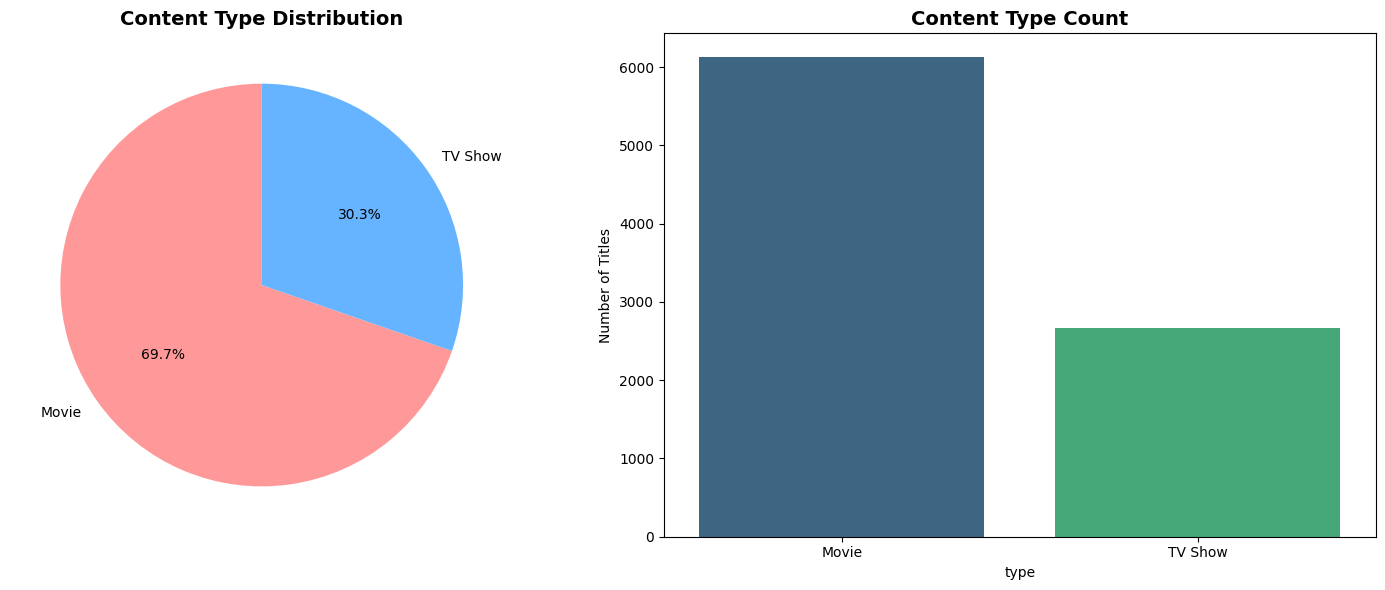


2. 📈 CONTENT GROWTH OVER TIME


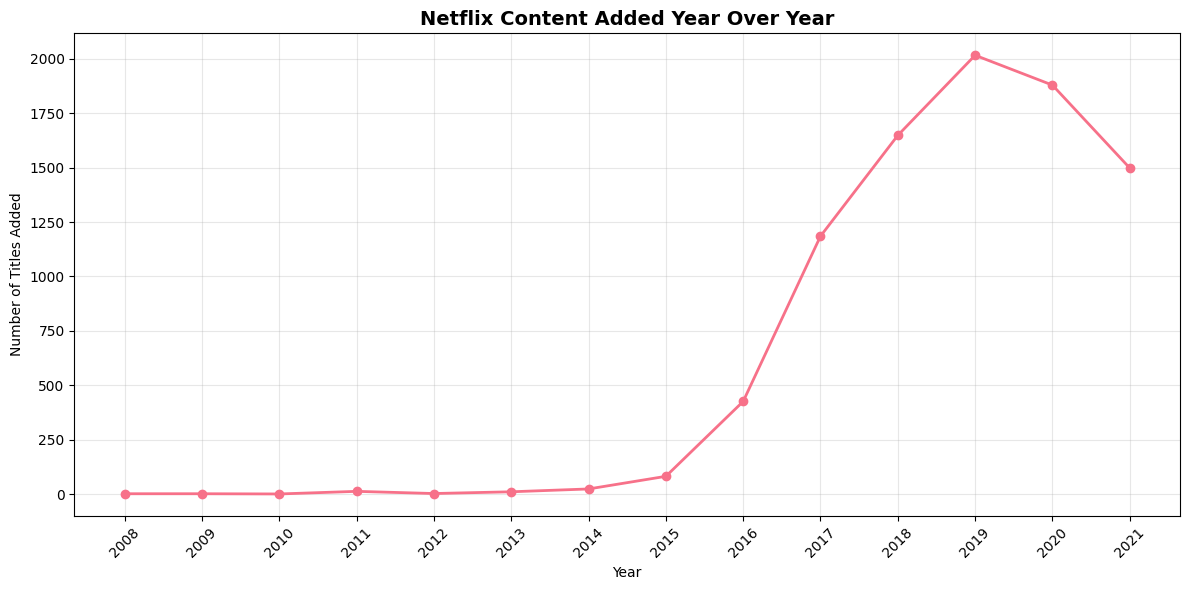

   Peak year: 2019 with 2016 titles
   Growth from 2008 to 2021: 74800.0%

3. 🌍 TOP COUNTRIES BY CONTENT


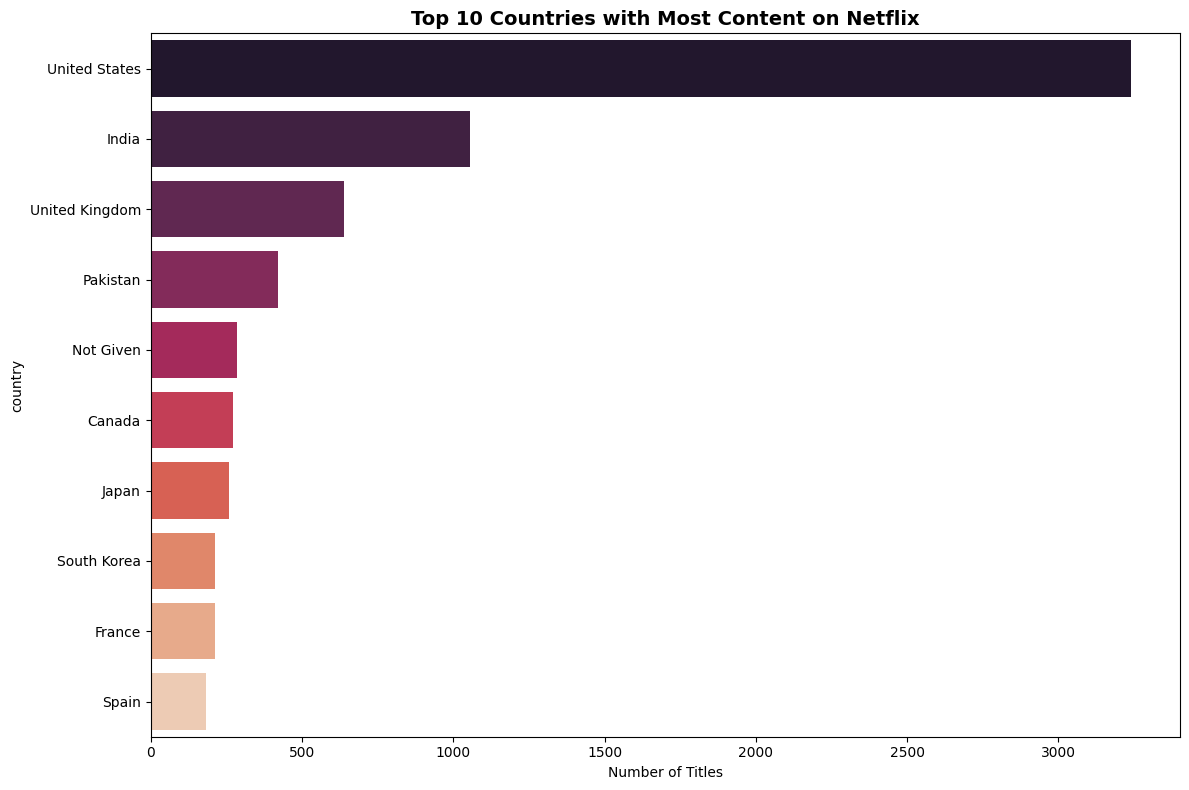

   Top 5 countries:
   1. United States: 3240 titles
   2. India: 1057 titles
   3. United Kingdom: 638 titles
   4. Pakistan: 421 titles
   5. Not Given: 287 titles

4. ⭐ CONTENT RATINGS DISTRIBUTION


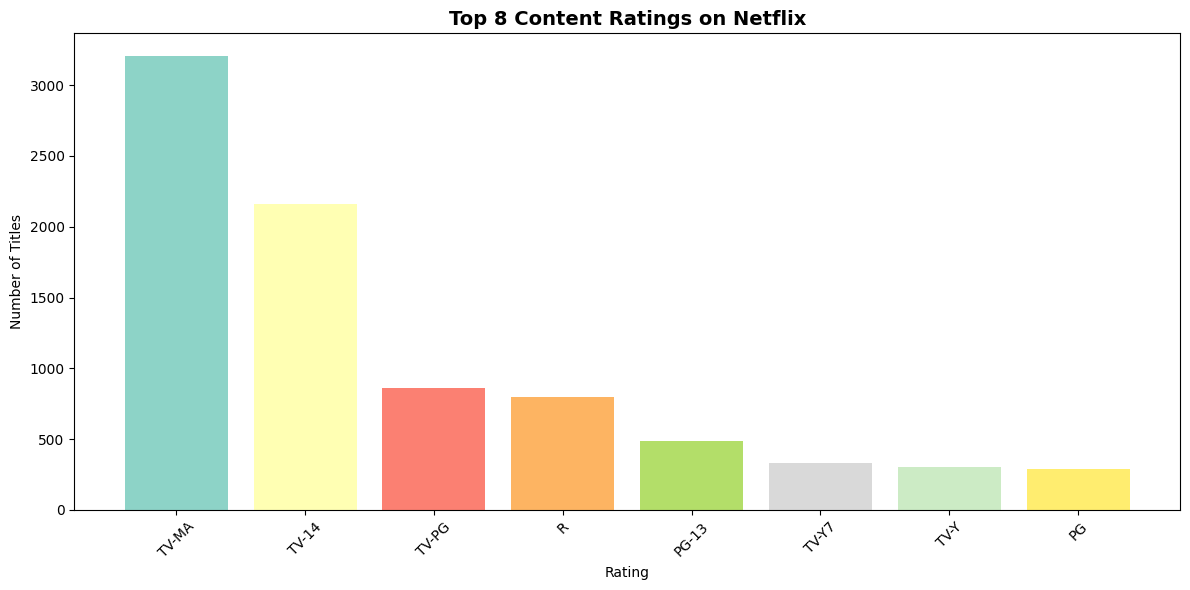

   Most common rating: TV-MA (3205 titles)

5. 🎭 GENRE ANALYSIS


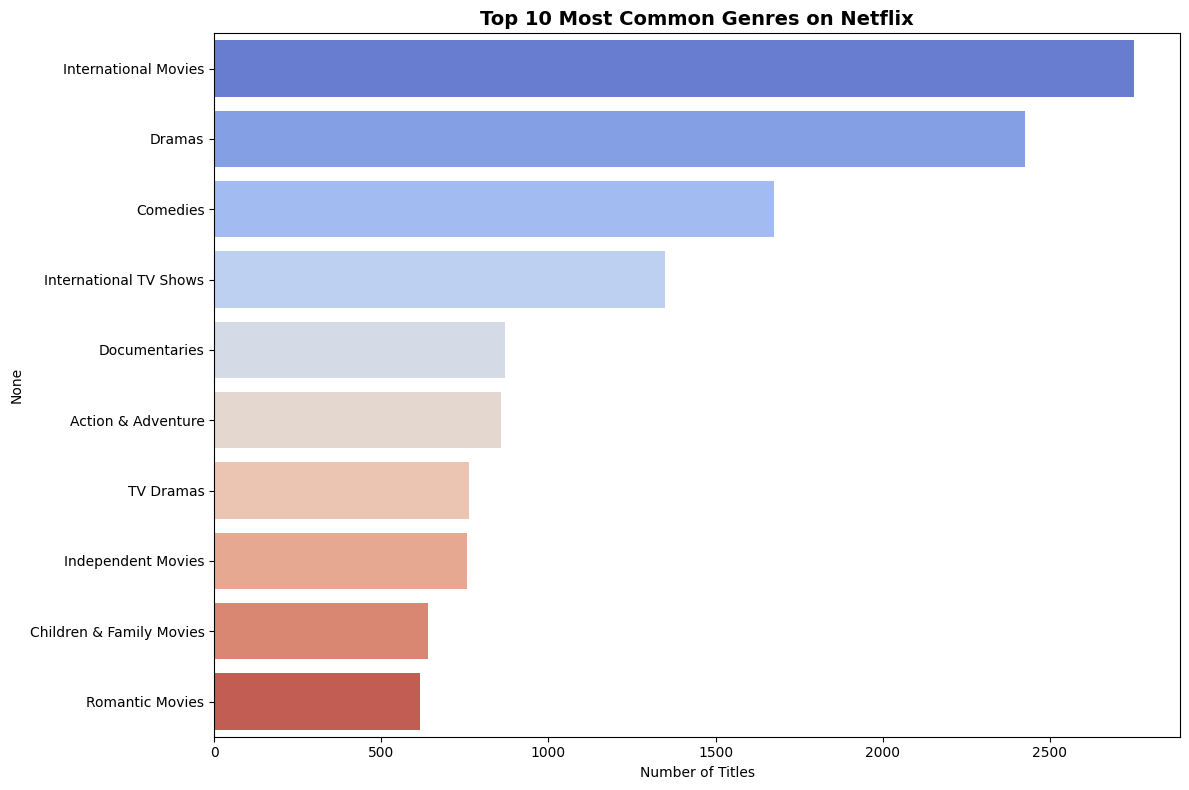

   Top 5 genres:
   1. International Movies: 2752 titles
   2. Dramas: 2426 titles
   3. Comedies: 1674 titles
   4. International TV Shows: 1349 titles
   5. Documentaries: 869 titles

6. ☁️  WORD CLOUD OF TITLES


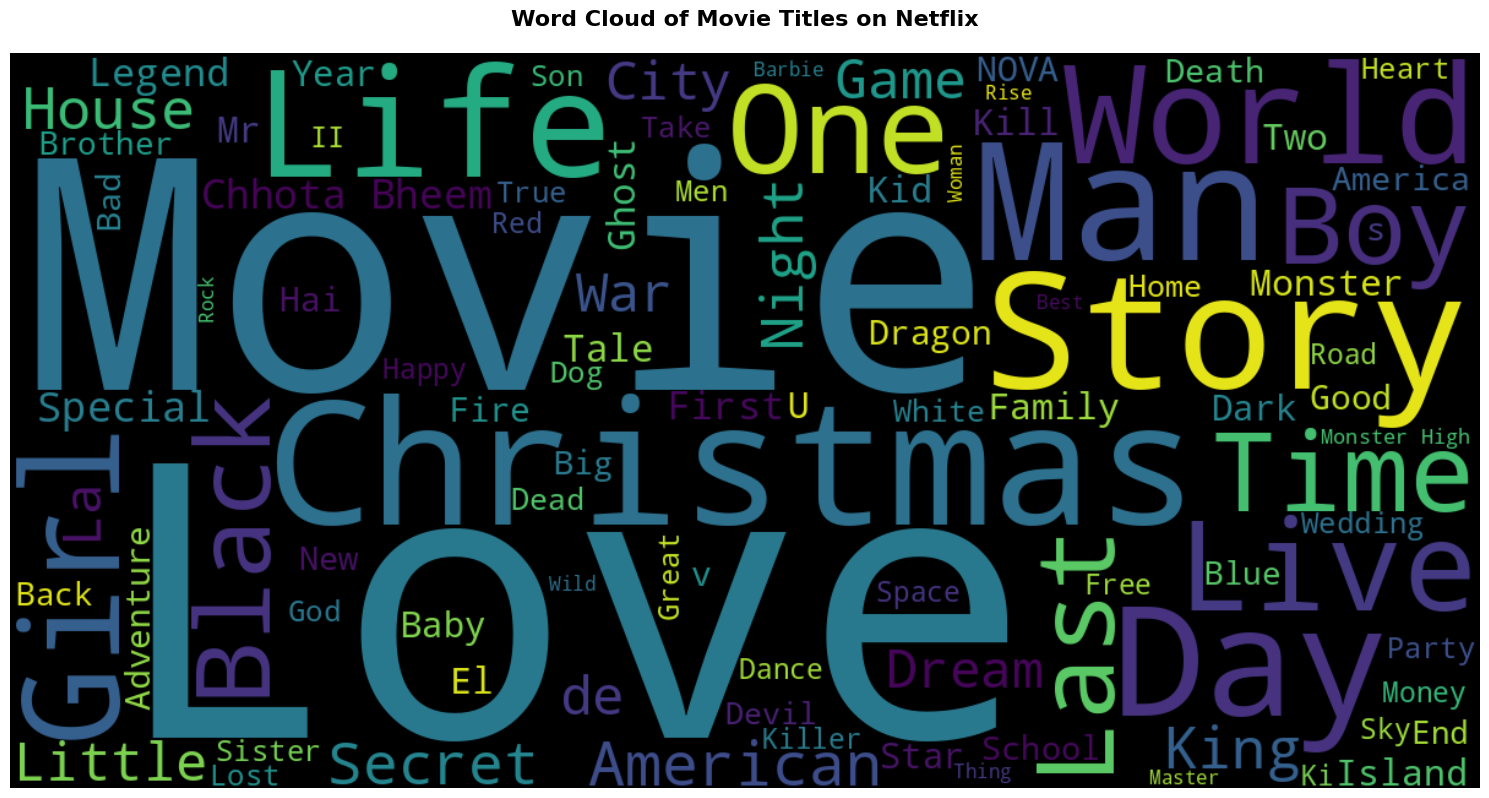

In [14]:
def create_comprehensive_analysis(df):
    """Create comprehensive visualizations and analysis"""

    if df is None:
        return

    print("\n" + "="*50)
    print("📊 EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # 1. Content Type Distribution
    print("\n1. 📺 CONTENT TYPE DISTRIBUTION")
    if 'type' in df.columns:
        type_counts = df['type'].value_counts()
        print(f"   {type_counts.to_dict()}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Pie chart
        ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
                startangle=90, colors=['#ff9999', '#66b3ff'])
        ax1.set_title('Content Type Distribution', fontsize=14, fontweight='bold')

        # Bar chart
        sns.barplot(x=type_counts.index, y=type_counts.values, ax=ax2, palette='viridis')
        ax2.set_title('Content Type Count', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Number of Titles')

        plt.tight_layout()
        plt.show()

    # 2. Content Added Over Time
    print("\n2. 📈 CONTENT GROWTH OVER TIME")
    if 'year_added' in df.columns:
        yearly_content = df['year_added'].value_counts().sort_index()

        plt.figure(figsize=(12, 6))
        plt.plot(yearly_content.index, yearly_content.values, marker='o', linewidth=2, markersize=6)
        plt.title('Netflix Content Added Year Over Year', fontsize=14, fontweight='bold')
        plt.xlabel('Year')
        plt.ylabel('Number of Titles Added')
        plt.grid(True, alpha=0.3)
        plt.xticks(yearly_content.index, rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"   Peak year: {yearly_content.idxmax()} with {yearly_content.max()} titles")
        growth = ((yearly_content.iloc[-1] - yearly_content.iloc[0]) / yearly_content.iloc[0]) * 100
        print(f"   Growth from {yearly_content.index[0]} to {yearly_content.index[-1]}: {growth:.1f}%")

    # 3. Top Countries
    print("\n3. 🌍 TOP COUNTRIES BY CONTENT")
    if 'country' in df.columns:
        # Get top 10 countries
        top_countries = df['country'].value_counts().head(10)

        plt.figure(figsize=(12, 8))
        sns.barplot(y=top_countries.index, x=top_countries.values, palette='rocket')
        plt.title('Top 10 Countries with Most Content on Netflix', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Titles')
        plt.tight_layout()
        plt.show()

        print("   Top 5 countries:")
        for i, (country, count) in enumerate(top_countries.head().items(), 1):
            print(f"   {i}. {country}: {count} titles")

    # 4. Rating Distribution
    print("\n4. ⭐ CONTENT RATINGS DISTRIBUTION")
    if 'rating' in df.columns:
        rating_counts = df['rating'].value_counts().head(8)

        plt.figure(figsize=(12, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, len(rating_counts)))
        plt.bar(rating_counts.index, rating_counts.values, color=colors)
        plt.title('Top 8 Content Ratings on Netflix', fontsize=14, fontweight='bold')
        plt.xlabel('Rating')
        plt.ylabel('Number of Titles')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"   Most common rating: {rating_counts.index[0]} ({rating_counts.iloc[0]} titles)")

    # 5. Genre Analysis
    print("\n5. 🎭 GENRE ANALYSIS")
    if 'genres_list' in df.columns:
        # Get all genres
        all_genres = []
        for genres in df['genres_list']:
            if isinstance(genres, list):
                all_genres.extend(genres)

        genre_counts = pd.Series(all_genres).value_counts().head(10)

        plt.figure(figsize=(12, 8))
        sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='coolwarm')
        plt.title('Top 10 Most Common Genres on Netflix', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Titles')
        plt.tight_layout()
        plt.show()

        print("   Top 5 genres:")
        for i, (genre, count) in enumerate(genre_counts.head().items(), 1):
            print(f"   {i}. {genre}: {count} titles")

    # 6. Word Cloud of Titles
    print("\n6. ☁️  WORD CLOUD OF TITLES")
    if 'title' in df.columns and 'type' in df.columns:
        movie_titles = ' '.join(df[df['type'] == 'Movie']['title'].dropna())

        plt.figure(figsize=(15, 8))
        wordcloud = WordCloud(width=1200, height=600,
                            background_color='black',
                            colormap='viridis',
                            max_words=100).generate(movie_titles)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Movie Titles on Netflix', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

# Run comprehensive analysis
create_comprehensive_analysis(df_clean)

# ==============================
# PHASE 4: EXPORT FOR POWER BI
# ==============================


In [15]:
def prepare_powerbi_export(df):
    """Prepare and export data optimized for Power BI"""

    if df is None:
        return None

    print("\n" + "="*50)
    print("📤 PREPARING DATA FOR POWER BI")
    print("="*50)

    # Create a Power BI optimized dataset
    powerbi_data = df.copy()

    # Create genre flags for better Power BI filtering
    if 'genres_list' in df.columns:
        all_genres = set()
        for genres in df['genres_list'].dropna():
            if isinstance(genres, list):
                all_genres.update(genres)

        # Take top 15 genres for flags
        top_genres = list(all_genres)[:15]
        print(f"   Creating flags for top {len(top_genres)} genres...")

        for genre in top_genres:
            clean_genre_name = genre.replace(" ", "_").replace("&", "and").replace(",", "").replace("-", "_")
            powerbi_data[f'genre_{clean_genre_name}'] = powerbi_data['genres_list'].apply(
                lambda x: 1 if isinstance(x, list) and genre in x else 0
            )

    # Create duration categories
    if 'duration_numeric' in df.columns:
        powerbi_data['duration_category'] = pd.cut(
            powerbi_data['duration_numeric'],
            bins=[0, 30, 60, 90, 120, 1000],
            labels=['Very Short (<30min)', 'Short (30-60min)', 'Medium (60-90min)',
                   'Long (90-120min)', 'Very Long (>120min)']
        )
        print("   ✅ Created duration categories")

    # Create age categories
    if 'content_age' in df.columns:
        powerbi_data['age_category'] = pd.cut(
            powerbi_data['content_age'],
            bins=[-1, 1, 5, 10, 20, 100],
            labels=['New (<1yr)', 'Recent (1-5yrs)', 'Moderate (5-10yrs)',
                   'Old (10-20yrs)', 'Classic (>20yrs)']
        )
        print("   ✅ Created age categories")

    # Select columns for Power BI export
    base_columns = ['show_id', 'type', 'title', 'director', 'country', 'date_added',
                   'year_added', 'month_added', 'quarter_added', 'release_year',
                   'rating', 'duration', 'duration_numeric', 'duration_type',
                   'duration_category', 'listed_in', 'genre_count', 'content_age',
                   'age_category']

    # Only include columns that exist in our dataframe
    available_columns = [col for col in base_columns if col in powerbi_data.columns]

    # Add genre flag columns
    genre_columns = [col for col in powerbi_data.columns if col.startswith('genre_')]
    export_columns = available_columns + genre_columns

    powerbi_export = powerbi_data[export_columns]

    # Export to CSV
    powerbi_export.to_csv('netflix_powerbi_ready.csv', index=False)
    print("✅ Data exported for Power BI: 'netflix_powerbi_ready.csv'")

    # Show export summary
    print(f"\n📦 EXPORT SUMMARY:")
    print(f"   Rows: {len(powerbi_export)}")
    print(f"   Columns: {len(powerbi_export.columns)}")
    print(f"   File size: {powerbi_export.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

    # Download the file
    from google.colab import files
    files.download('netflix_powerbi_ready.csv')
    print("📥 File downloaded to your computer!")

    return powerbi_export

# Export for Power BI
powerbi_df = prepare_powerbi_export(df_clean)

print("\n" + "="*50)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*50)
print("📊 What you accomplished:")
print("   ✅ Data loading and exploration")
print("   ✅ Advanced data cleaning")
print("   ✅ Comprehensive visualization analysis")
print("   ✅ Power BI ready dataset exported")
print("   ✅ File downloaded to your computer")
print("\n🚀 Next step: Import 'netflix_powerbi_ready.csv' into Power BI!")


📤 PREPARING DATA FOR POWER BI
   Creating flags for top 15 genres...
   ✅ Created duration categories
✅ Data exported for Power BI: 'netflix_powerbi_ready.csv'

📦 EXPORT SUMMARY:
   Rows: 8790
   Columns: 33
   File size: 6.04 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 File downloaded to your computer!

🎉 PROJECT COMPLETED SUCCESSFULLY!
📊 What you accomplished:
   ✅ Data loading and exploration
   ✅ Advanced data cleaning
   ✅ Comprehensive visualization analysis
   ✅ Power BI ready dataset exported
   ✅ File downloaded to your computer

🚀 Next step: Import 'netflix_powerbi_ready.csv' into Power BI!
